In [2]:
rm(list = ls())
options(stringsAsFactors = F)
gc()
library(ConsensusClusterPlus)
library(survival)
library(survminer)
library(pheatmap)
library(scatterplot3d)
library(limma)
library(VennDiagram)
library(plyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(glmnet)
library(survival)
library(survivalROC)
library(survminer)
library(timeROC)
library("clusterProfiler")
library("org.Hs.eg.db")
library("enrichplot")
library("ggplot2")
source('./00.data/fun.R',print.eval = TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,5408671,288.9,8534168,455.8,6959402,371.7
Vcells,9003156,68.7,14932834,114.0,11370147,86.8


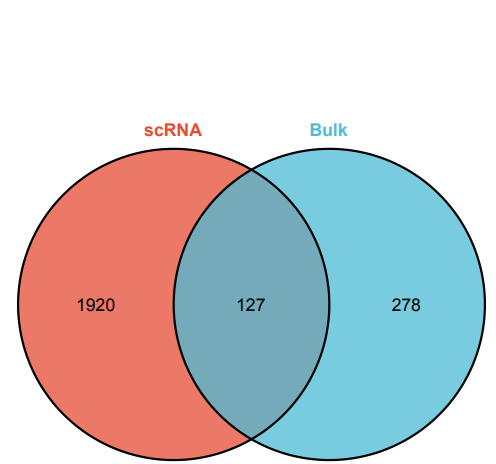

In [3]:
input <- './fig4/05.model/cox_input.txt'
rt <- read.table(input,header = T,row.names = 1,check.names = F,sep = '\t')
surSigExp <- Processing_2(rt)
surSigExp  <- as.data.frame(t(as.data.frame(surSigExp, check.names = FALSE)))
write.table(surSigExp, file = paste('./05.model/','LIHC', "_uni_cox_os.txt",sep=""), sep = "\t", quote = F, row.names = T)
res_results_0.05 <- na.omit(surSigExp[which(as.numeric(surSigExp$p.value) < 0.05),])
write.table(res_results_0.05, file = paste('./05.model/','LIHC', "_uni_cox_os_sig.txt",sep=""), sep = "\t", quote = F, row.names = T)

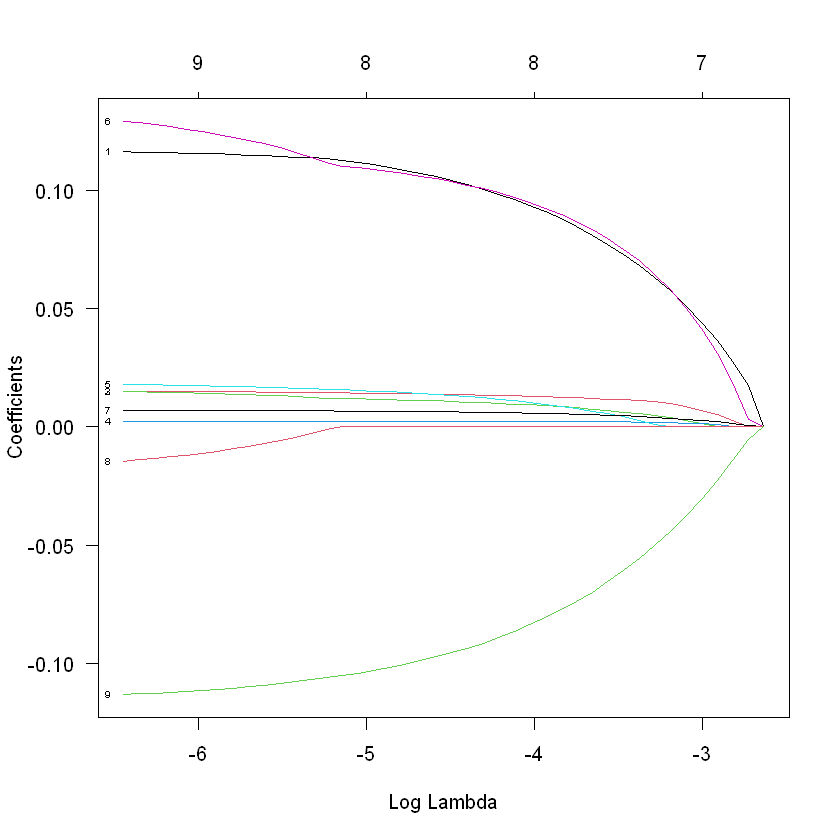

In [4]:
x_all <- subset(rt, select = -c(futime,fustat))
x <- x_all[,rownames(res_results_0.05)]
y <- subset(rt, select = c(futime,fustat))
fit <- glmnet(as.matrix(x), Surv(y$futime,y$fustat), 
                family = "cox") 
plot(fit, xvar = "lambda",label = TRUE, las=1)

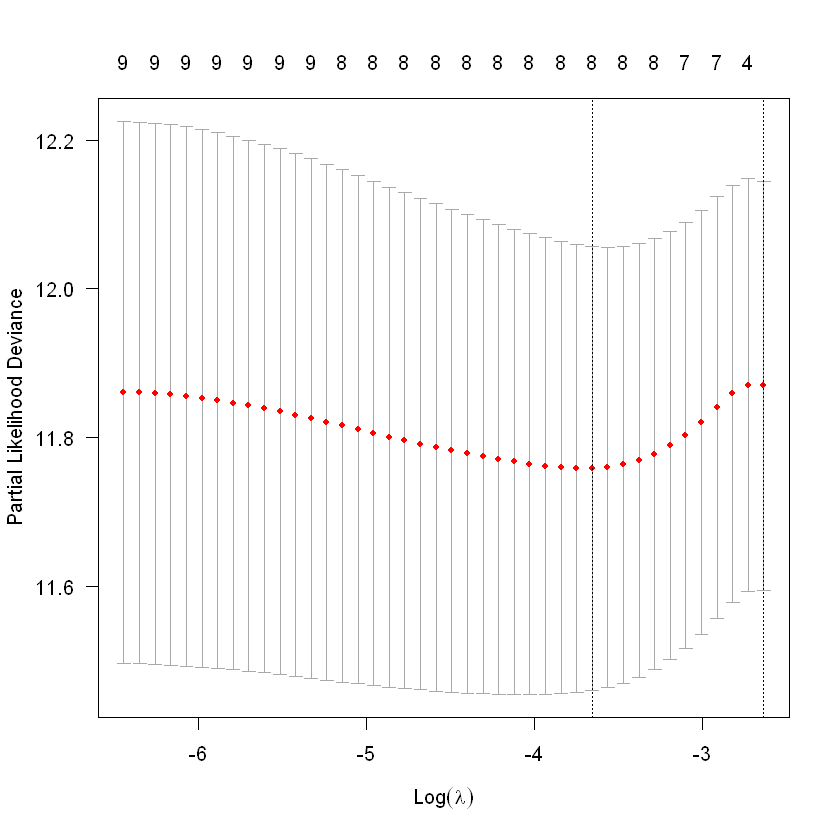

In [5]:
set.seed(123)
cvfit = cv.glmnet(as.matrix(x),
                    Surv(y$futime,y$fustat),
                    nfold=10,
                    family = "cox") 
plot(cvfit, las =1)

In [6]:
coef.min = coef(cvfit, s = cvfit$lambda.min)
cvfit$lambda.min
df.coef = cbind(gene = rownames(coef.min), coefficient = coef.min[,1]) %>% as.data.frame()
df.coef = subset(df.coef, coefficient != 0) %>% as.data.frame
df.coef

[1] 0.02585495

,gene,coefficient
,<chr>,<chr>
PDLIM3,PDLIM3,0.0811490229987895
PAM,PAM,0.012068427322665
PDLIM7,PDLIM7,0.00750594425793754
FSCN1,FSCN1,0.00223616172383073
DPYSL2,DPYSL2,0.00666301413803827
ARID5B,ARID5B,0.0834786986449922
LGALS3,LGALS3,0.00513018157156364
KLF2,KLF2,-0.0699260942304834


In [7]:
genes = rownames(df.coef)
genes

[1] "PDLIM3" "PAM"    "PDLIM7" "FSCN1"  "DPYSL2" "ARID5B" "LGALS3" "KLF2"

In [8]:
entrezIDs=mget(genes, org.Hs.egSYMBOL2EG, ifnotfound=NA)
entrezIDs=as.character(entrezIDs)
gene=entrezIDs[entrezIDs!="NA"]
gene

[1] "27295" "5066"  "9260"  "6624"  "1808"  "84159" "3958"  "10365"

In [9]:
pvalueFilter=0.05      
qvalueFilter=0.05 
kk=enrichGO(gene=gene, OrgDb=org.Hs.eg.db, pvalueCutoff=1, qvalueCutoff=1, ont="all", readable=T)
GO=as.data.frame(kk)
GO=GO[(GO$pvalue<pvalueFilter & GO$qvalue<qvalueFilter),]

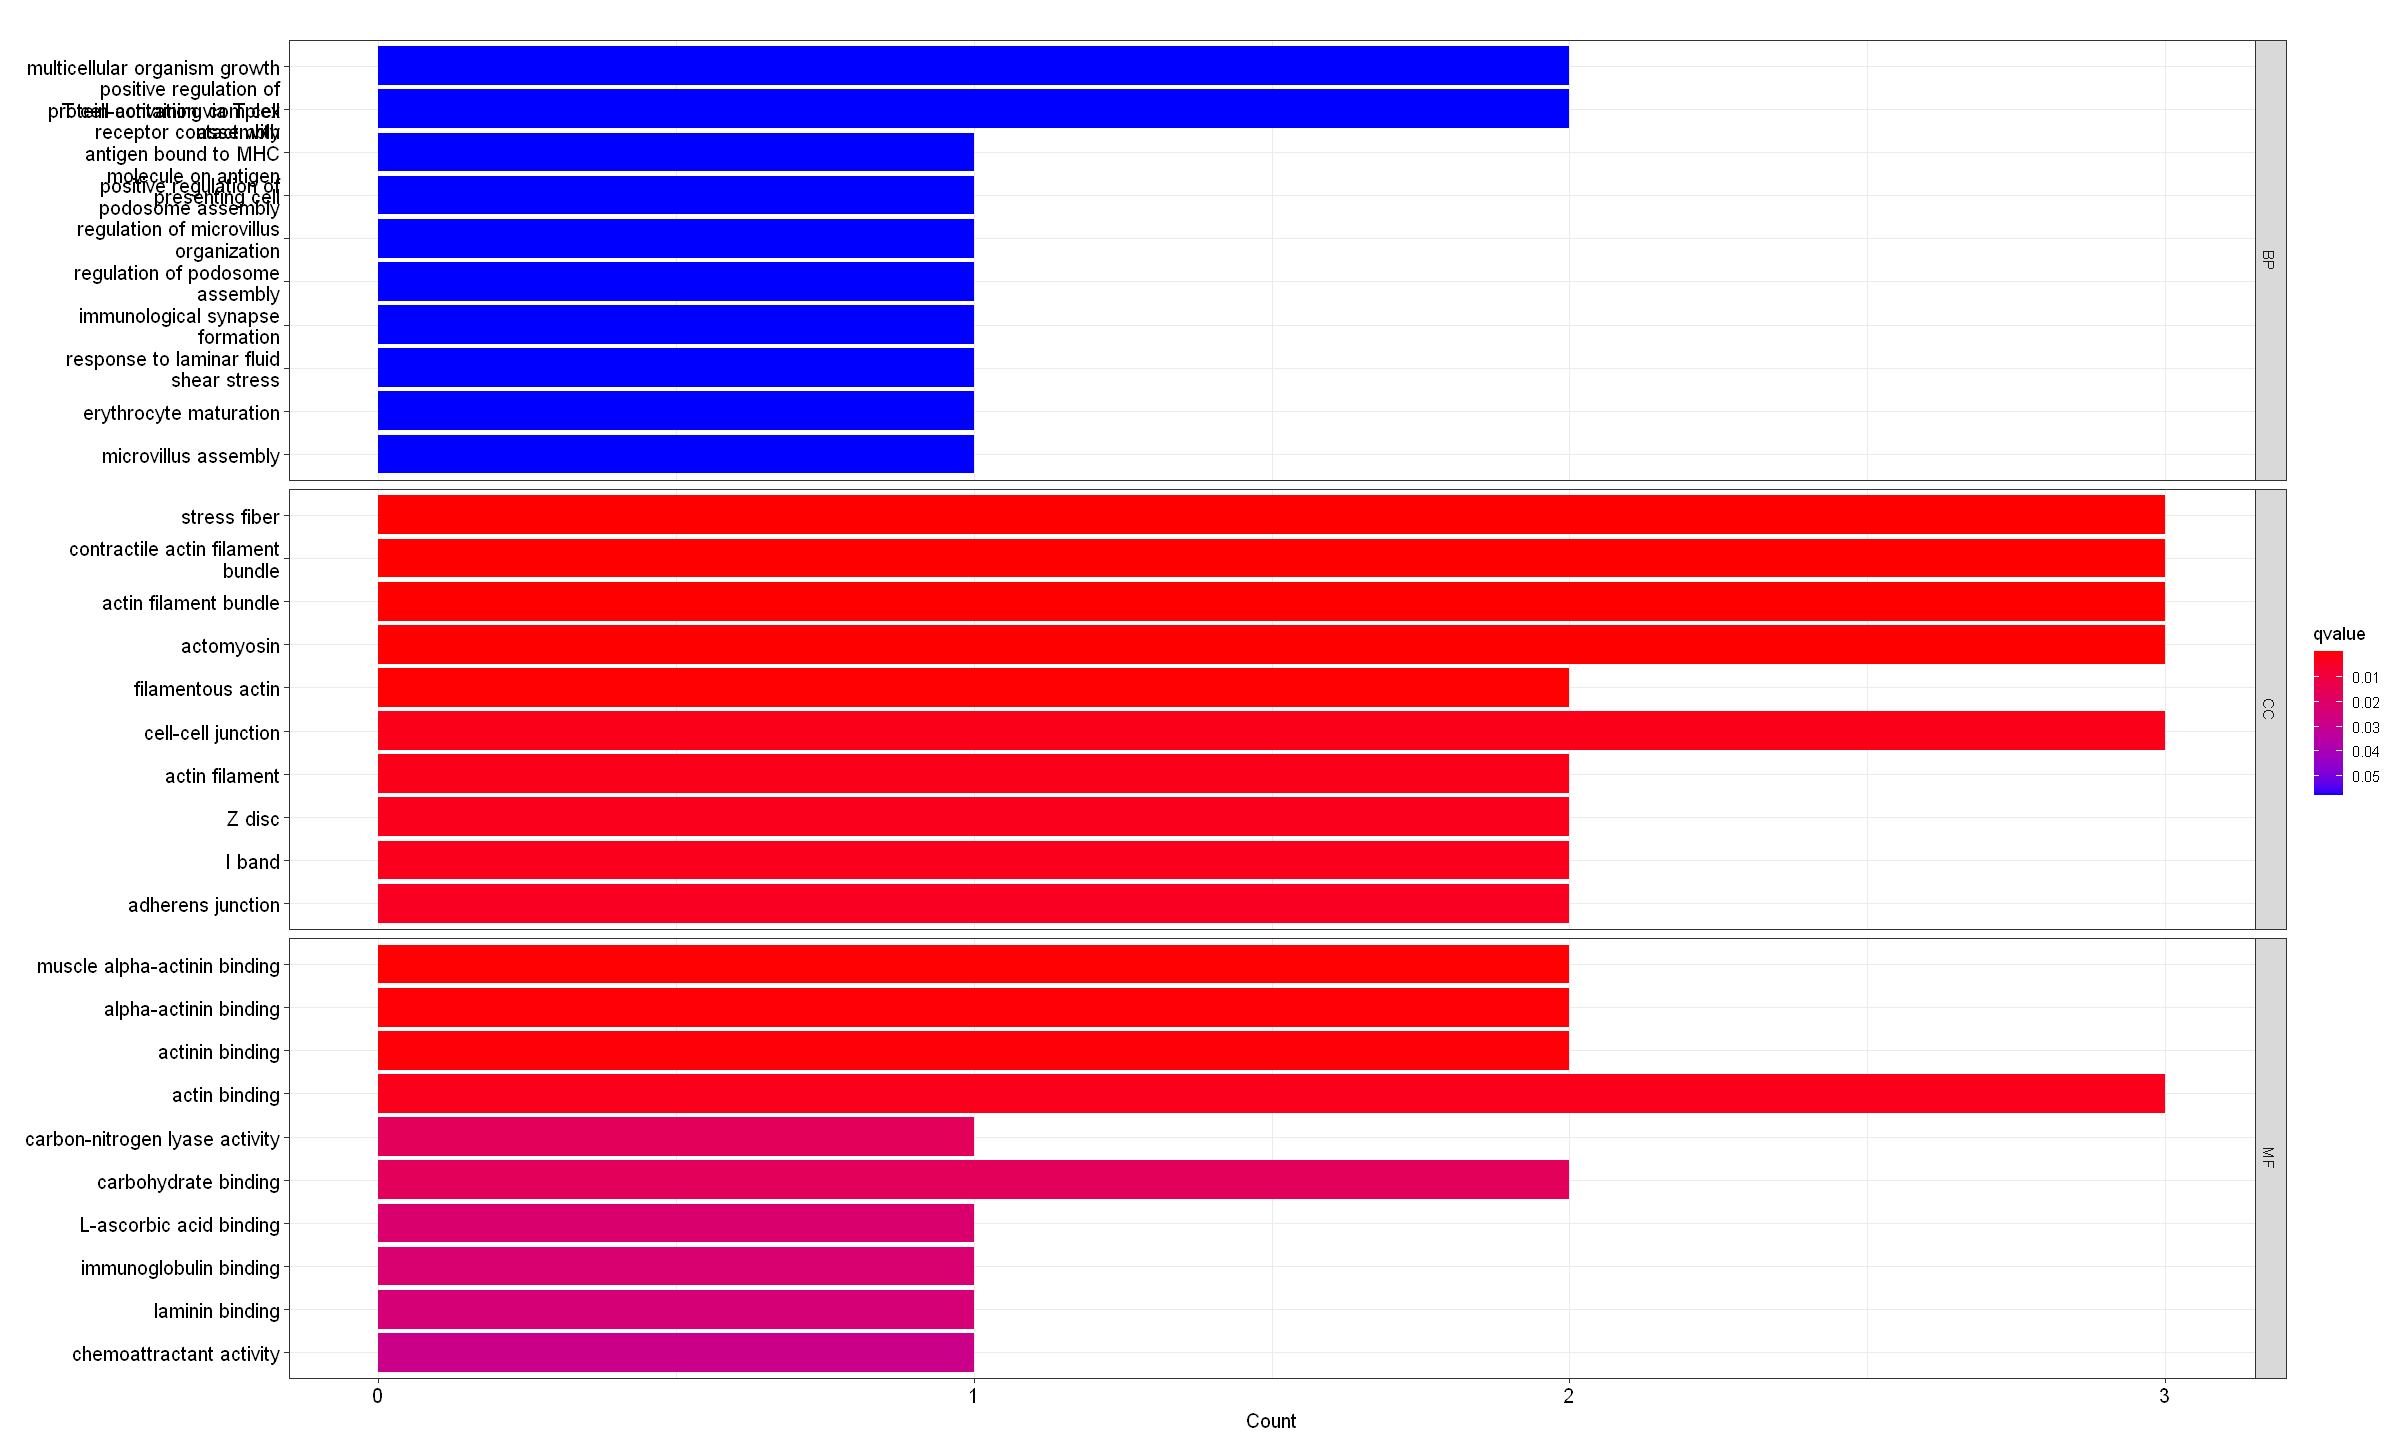

In [11]:
colorSel="qvalue"
if(qvalueFilter>0.05){
  colorSel="pvalue"
}
showNum=10
if(nrow(GO)<30){
  showNum=nrow(GO)
}
options(repr.plot.width = 20, repr.plot.height = 12)
bar=barplot(kk, drop=TRUE, showCategory=showNum, split="ONTOLOGY", color=colorSel) + facet_grid(ONTOLOGY~., scale='free')
print(bar)

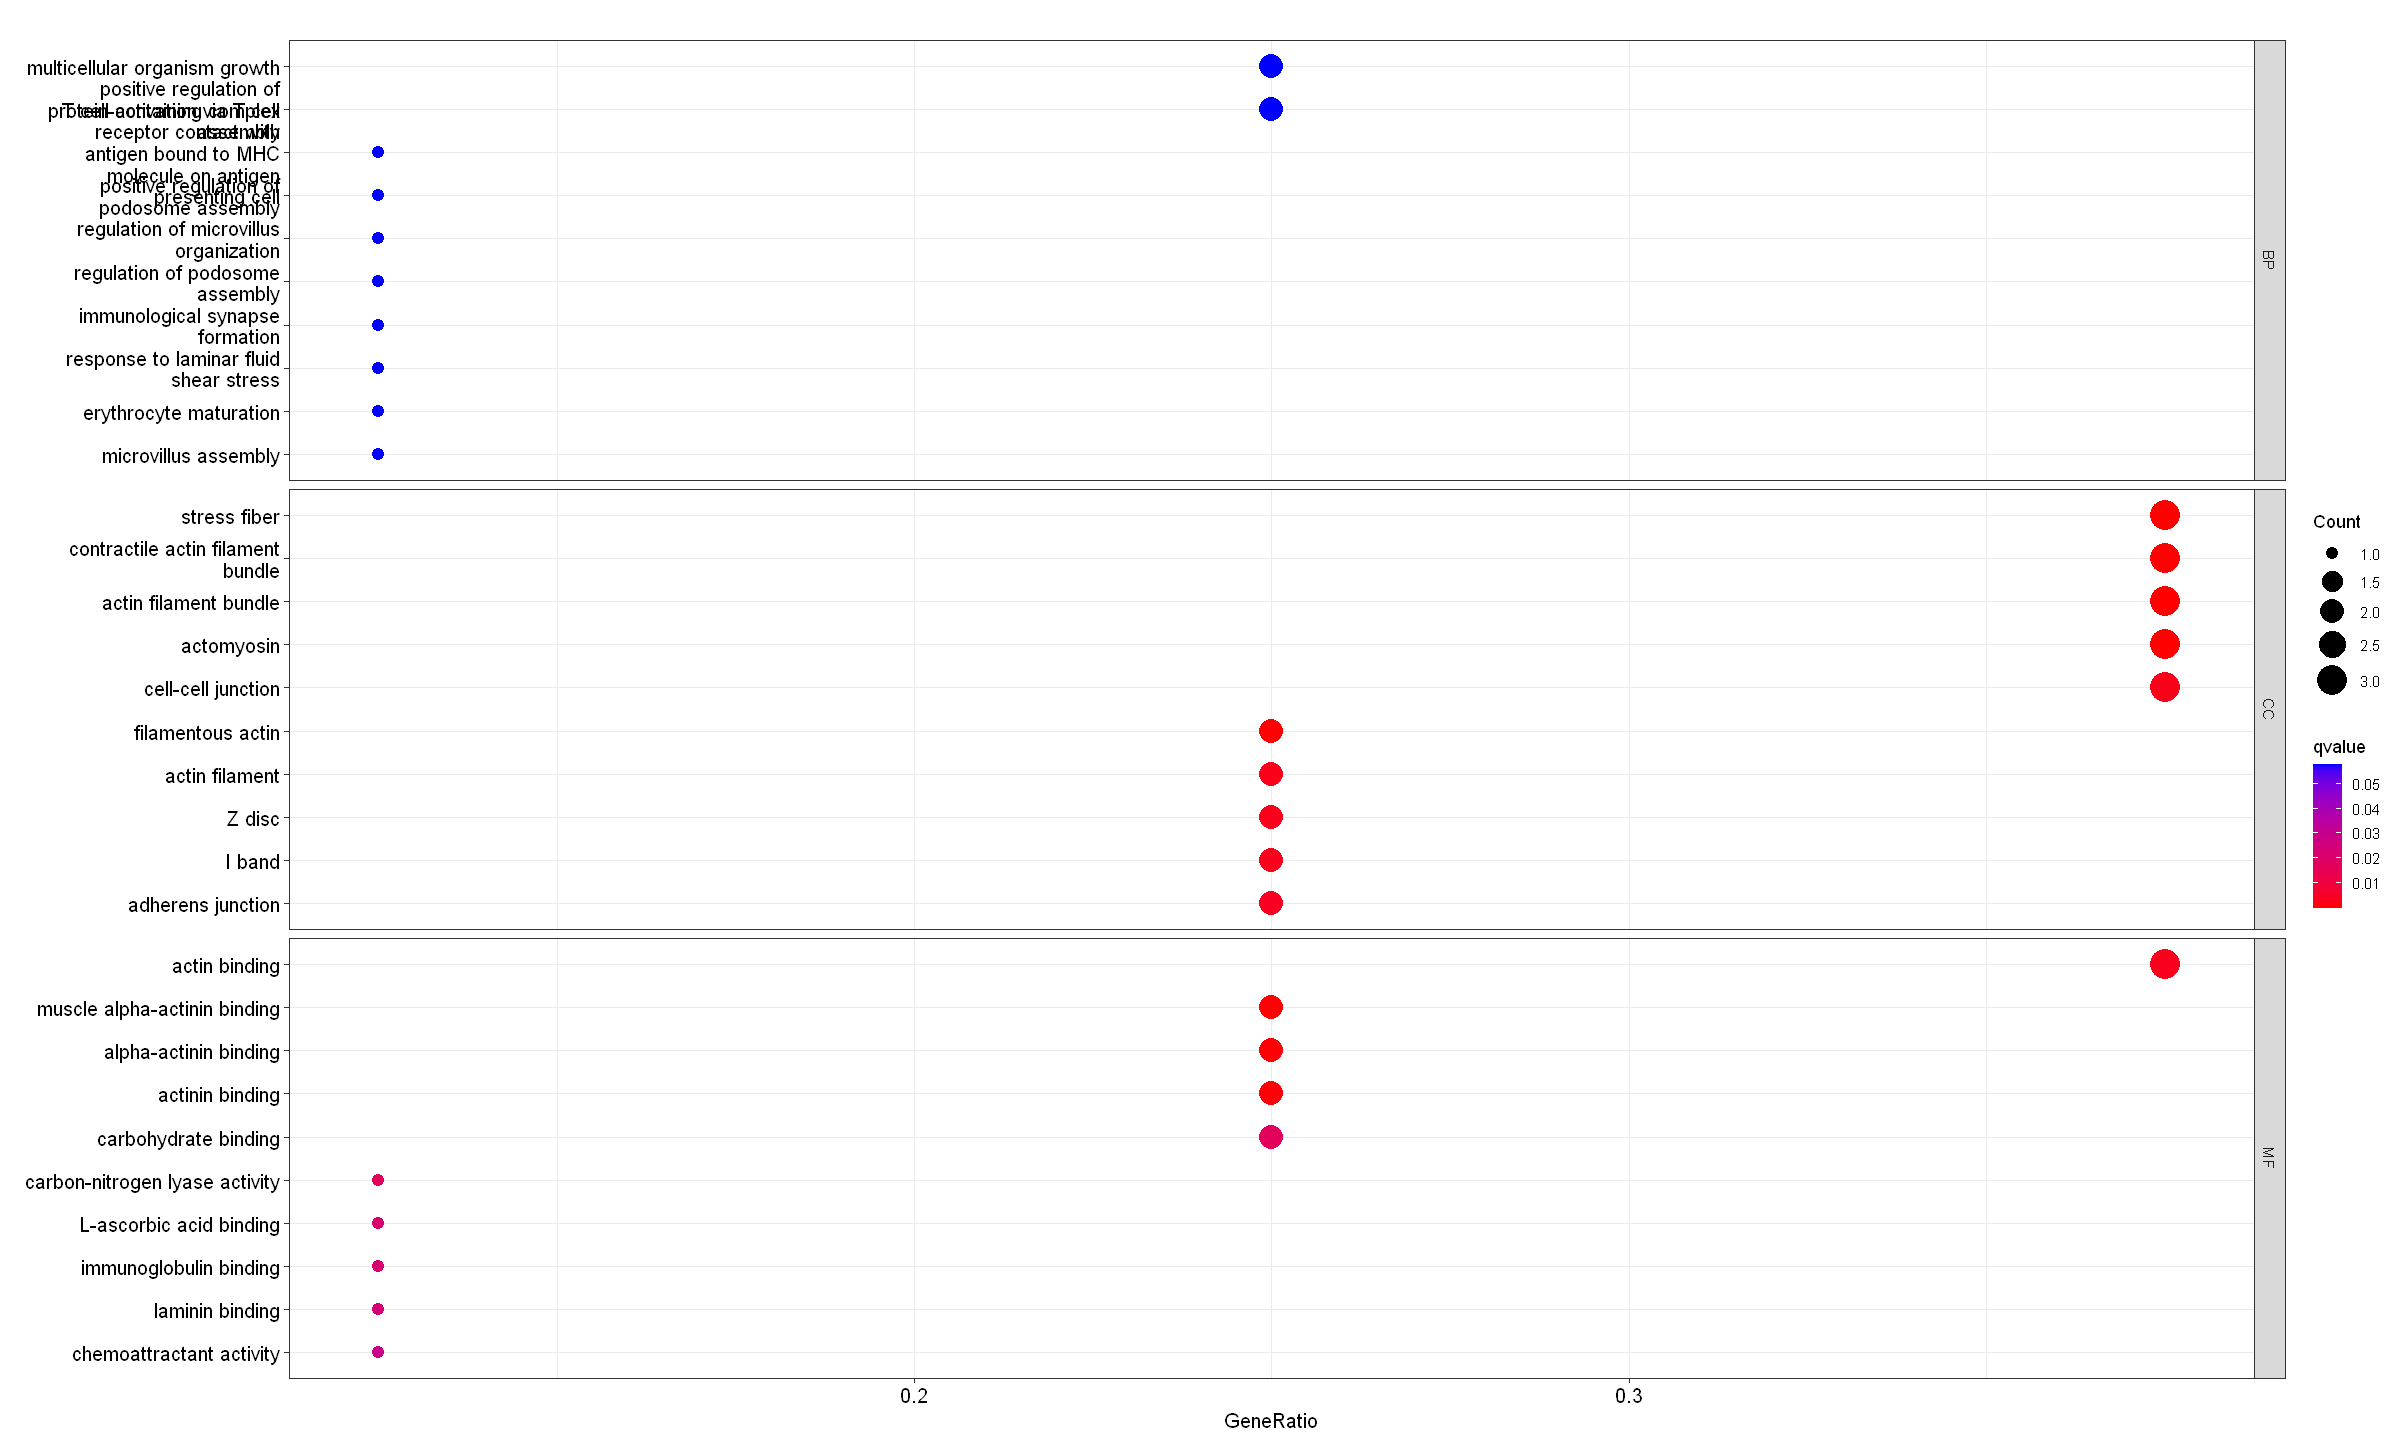

In [12]:
bub=dotplot(kk, showCategory=showNum, orderBy="GeneRatio", split="ONTOLOGY", color=colorSel) + facet_grid(ONTOLOGY~., scale='free')
print(bub)

In [13]:
data=read.table('./fig3/06.cluster/cluster.txt', header=T, sep="\t", check.names=F, row.names=1)
data=as.matrix(data)
group=sapply(strsplit(colnames(data),"\\-"), "[", 4)
table(group)

group
01A 01B 02A 02B 
363   2   2   1 

In [14]:
maxK=8
results=ConsensusClusterPlus(data,
                             maxK=maxK,
                             reps=1000,
                             pItem=0.8,
                             pFeature=1,
                             title='./06.cluster/',
                             clusterAlg="pam",
                             distance="pearson",
                             innerLinkage="complete",
                             seed=123456,
                             plot="png")

end fraction

Warning message in dir.create(paste(title, sep = "")):
"'.\06.cluster'已存在"
clustered

clustered

clustered

clustered

clustered

clustered

clustered



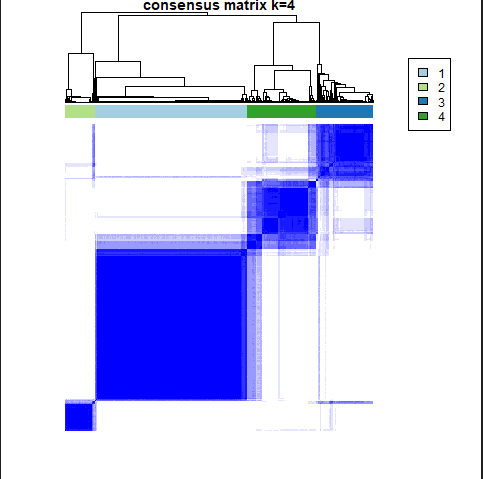

In [15]:
clusterNum=4     
cluster=results[[clusterNum]][["consensusClass"]]
cluster=as.data.frame(cluster)
colnames(cluster)=c("cluster")
letter=c("A","B","C","D","E","F","G")
uniqClu=levels(factor(cluster$cluster))
cluster$cluster=letter[match(cluster$cluster, uniqClu)]
clusterOut=rbind(ID=colnames(cluster), cluster)
write.table(clusterOut, file="./fig3/06.cluster/Cluster1.txt", sep="\t", quote=F, col.names=F)

In [16]:
cli <-data.table::fread('./00.data/01.TCGA/TCGA-LIHC.survival.tsv',data.table = F)
row.names(cli) <- cli[,1]
cli$futime <- cli$OS.time/365
cli$fustat <- cli$OS
cli <- cli[,-c(1:4)]
sameSample=intersect(row.names(cluster), row.names(cli))
rt=cbind(cli[sameSample,,drop=F], cluster[sameSample,,drop=F])

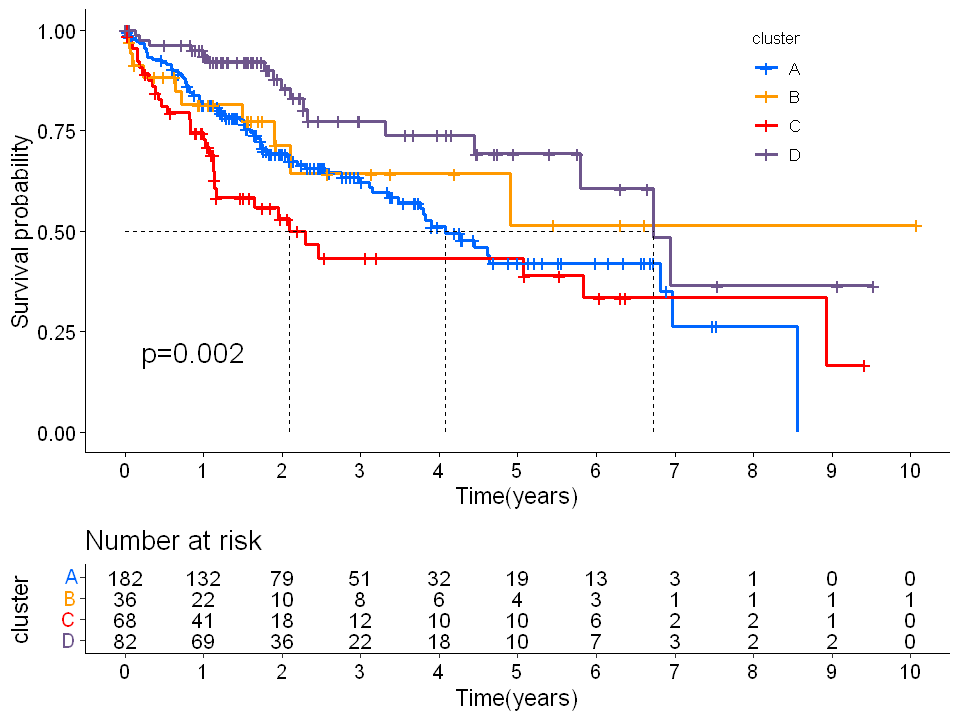

In [17]:
length=length(levels(factor(rt$cluster)))
diff=survdiff(Surv(futime, fustat) ~ cluster, data = rt)
pValue=1-pchisq(diff$chisq, df=length-1)
if(pValue<0.001){
  pValue="p<0.001"
}else{
  pValue=paste0("p=",sprintf("%.03f",pValue))
}
fit <- survfit(Surv(futime, fustat) ~ cluster, data = rt)
bioCol=c("#0066FF","#FF9900","#FF0000","#6E568C","#7CC767","#223D6C","#D20A13","#FFD121","#088247","#11AA4D")
bioCol=bioCol[1:length]
options(repr.plot.width = 8, repr.plot.height = 6)
ggsurvplot(fit, 
                   data=rt,
                   conf.int=F,
                   pval=pValue,
                   pval.size=6,
                   legend.title="cluster",
                   legend.labs=levels(factor(rt[,"cluster"])),
                   legend = c(0.8, 0.8),
                   font.legend=10,
                   xlab="Time(years)",
                   break.time.by = 1,
                   palette = bioCol,
                   surv.median.line = "hv",
                   risk.table=T,
                   cumevents=F,
                   risk.table.height=.28)

# heatmap

In [18]:
data=read.table('./fig3/06.cluster/cluster.txt', header=T, sep="\t", check.names=F, row.names=1)
exp=t(data)
cluster <-read.table('./fig3/06.cluster/Cluster1.txt', header=T, sep="\t", check.names=F, row.names=1) 

In [19]:
sameSample=intersect(row.names(exp), row.names(cluster))
exp=exp[sameSample, , drop=F]
cluster=cluster[sameSample, , drop=F]
expCluster=cbind(exp, cluster)

In [20]:
cli=read.csv("./fig3/06.cluster/clinical.csv", row.names = 1, header = T)
sameSample=intersect(row.names(expCluster), row.names(cli))
expCluster=expCluster[sameSample,,drop=F]
cli=cli[sameSample,,drop=F]
data=cbind(expCluster, cli)
data=data[order(data$cluster),]
Type=data[,((ncol(exp)+1):ncol(data))]
data=t(data[,1:ncol(exp)])
data[1:8,360:368]

,TCGA-DD-AACF-01A,TCGA-G3-A25Z-01A,TCGA-DD-A4NB-01A,TCGA-DD-A11C-01A,TCGA-DD-AAEB-01A,TCGA-DD-AAVY-01A,TCGA-ED-A7XO-01A,TCGA-G3-A7M6-01A,TCGA-DD-AADF-01A
PDLIM3,0.1853293,0.9763062,4.357293,0.7706999,0.2555972,0.0844540,1.848243,1.521621,0.3833594
PAM,0.6885131,2.1648390,7.666787,2.3458740,0.7081752,0.6300131,1.836935,2.261082,0.7095741
PDLIM7,2.3895670,3.5361860,10.795440,3.1726070,2.1356720,1.3228390,4.465555,8.219414,3.3719230
FSCN1,5.8749590,3.3139840,13.971600,10.4616000,3.1968350,2.4628780,10.430150,15.795340,1.3716980
DPYSL2,3.5661130,2.5202740,8.770593,5.6953310,2.7594080,1.7365490,5.694926,16.276150,1.5846240
ARID5B,0.4067066,0.8274706,6.498026,1.5624650,0.5782810,0.5209642,1.622365,4.902182,0.4455836
LGALS3,7.2703120,5.1346320,28.673070,4.2394720,4.4694340,2.6768430,9.275577,13.909890,2.5591300
KLF2,2.4145040,2.7441750,18.917780,10.7988300,7.2884030,1.4898600,15.025160,11.930250,2.3328390


In [21]:
 bioCol=c("#0066FF","#FF9900","#FF0000","#6E568C","#7CC767","#223D6C","#D20A13","#FFD121","#088247","#11AA4D")
  ann_colors=list()
  CluCol=bioCol[1:length(levels(factor(Type$cluster)))]
  names(CluCol)=levels(factor(Type$cluster))
  ann_colors[["cluster"]]=CluCol

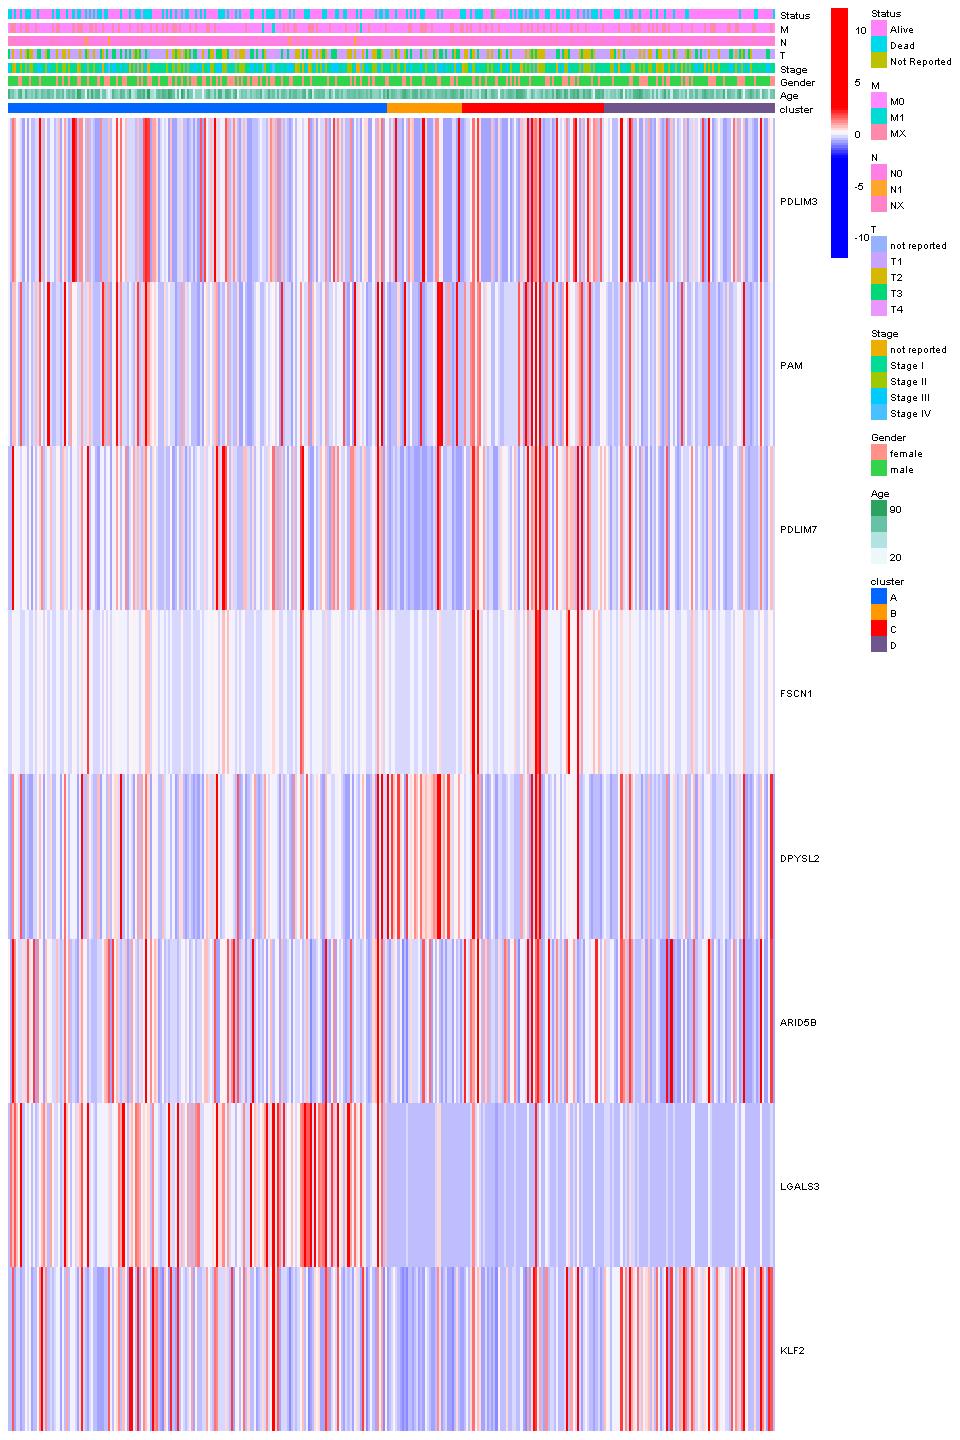

In [22]:
options(repr.plot.width = 8, repr.plot.height = 12)
pheatmap(data,
           annotation=Type,
           annotation_colors = ann_colors,
           color = colorRampPalette(c(rep("blue",5), "white", rep("red",5)))(100),
           cluster_cols =F,
           cluster_rows =F,
           scale="row",
           show_colnames=F,
           fontsize=6,
           fontsize_row=6,
           fontsize_col=6)

## PCA

In [23]:
cluster <-read.table('./fig3/06.cluster/Cluster1.txt', header=T, sep="\t", check.names=F, row.names=1) 
data=read.table('./fig3/06.cluster/cluster.txt', header=T, sep="\t", check.names=F, row.names=1)
data=t(data)
rt <- cbind(cluster,data)
data1=rt[,c(2:ncol(rt))]
Type=rt[,1] 
var=colnames(rt)[1]
group=levels(factor(Type))
bioCol=c("red","blue","green","yellow")
col= bioCol[match(Type,group)]

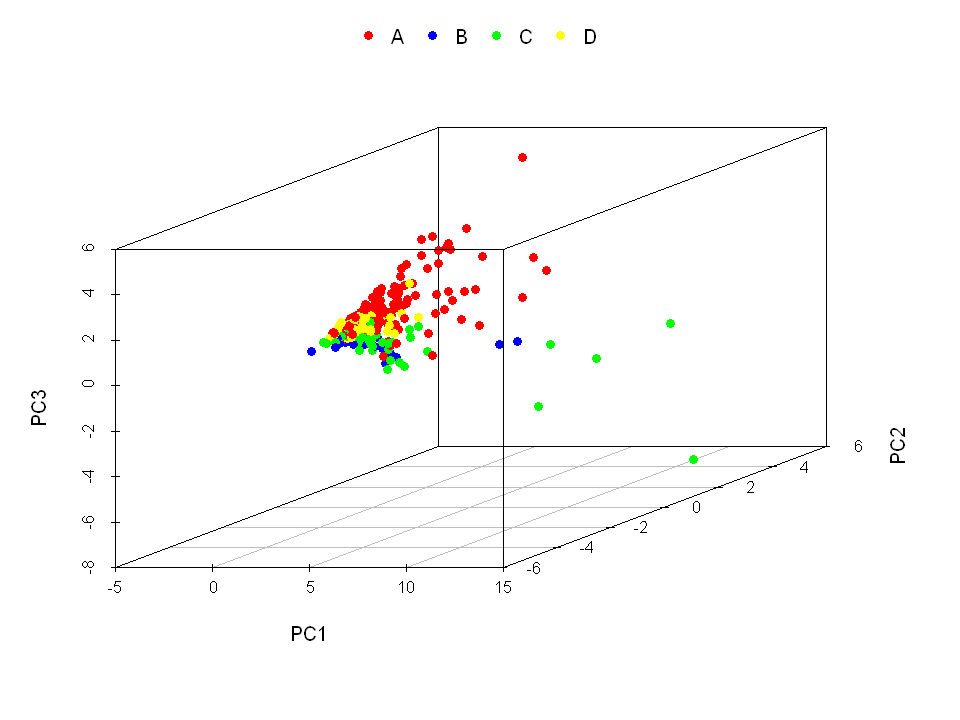

In [25]:
data.pca=prcomp(data1, scale. = TRUE)
pcaPredict=predict(data.pca)
options(repr.plot.width = 8, repr.plot.height = 6)
par(oma=c(0.5,0.5,0.5,0.5))
s3d=scatterplot3d(pcaPredict[,1:3], pch = 16, color=col)
legend("top", legend =group,pch = 16, inset = -0.2, box.col="white",xpd = TRUE, horiz = TRUE,col=bioCol[1:length(group)])